In [1]:
import math
import gym
from gym import spaces, logger
from gym.utils import seeding
import numpy as np
import sys
import os
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
from collections import deque
from collections import namedtuple
import time
import matplotlib.pyplot as plt
import pandas as pd
import hpbandster.core.nameserver as hpns
import hpbandster.core.result as hpres
import pickle
from hpbandster.optimizers import BOHB as BOHB
import ConfigSpace as CS
import ConfigSpace.hyperparameters as CSH
from hpbandster.core.worker import Worker
import logging
from utils import tt, soft_update, hard_update, cos_ann_w_restarts
from utils import exponential_decay_w_restarts, angle_normalize
from utils import plot_episode_stats, continous_plot, acton_discrete
from utils import smooth_reward
from continuous_cartpole import ContinuousCartPoleEnv
from replay_buffer import ReplayBuffer

logging.basicConfig(level=logging.DEBUG)
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards",
                                   "episode_loss", "episode_epsilon"])
%matplotlib notebook

DEBUG:matplotlib.pyplot:Loaded backend nbAgg version unknown.


In [2]:
class Q(nn.Module):
    def __init__(self, state_dim, action_dim, non_linearity=F.relu,
                 hidden_dim=30, dropout_rate=0.0):
        super(Q, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, action_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self._non_linearity = non_linearity

    def forward(self, x):
        x = self._non_linearity(self.fc1(x))
        x = self.dropout(self._non_linearity(self.fc2(x)))
        x = self.dropout(self._non_linearity(self.fc3(x)))
        return self.fc4(x)

class DQN:
    def __init__(self, state_dim, action_dim, gamma,
                 conf={'lr':0.001, 'bs':64, 'loss':nn.MSELoss, 'hidden_dim':64,
                       'activation':'relu',
                       'mem_size':50000, 'epsilon':1., 'eps_scheduler':'exp',
                       'n_episodes':1000, 'n_cycles':1, 'subtract':0.,
                      }):
        if conf['activation'] == 'relu':

            activation = torch.relu
        elif conf['activation'] == 'tanh':
            activation = torch.tanh

        self._q = Q(state_dim, action_dim,
                    non_linearity=activation, hidden_dim=conf['hidden_dim'],
                    dropout_rate=conf['dropout_rate']).to(device)
        self._q_target = Q(state_dim, action_dim,
                    non_linearity=activation, hidden_dim=conf['hidden_dim'],
                    dropout_rate=0.0).to(device)

        self._gamma = gamma
        ############################
        # exploration exploitation tradeoff
        self.epsilon = conf['epsilon']
        self.n_episodes = conf['n_episodes']
        self.n_cycles = conf['n_cycles']
        self.eps_scheduler = conf['eps_scheduler']
        ############################
        # Network
        self.bs = conf['bs']
        self._loss_function = nn.MSELoss()  # conf['loss']
        self._q_optimizer = optim.Adam(self._q.parameters(), lr=conf['lr'])
        self._action_dim = action_dim
        self._replay_buffer = ReplayBuffer(conf['mem_size'])
        self.scheduler = StepLR(self._q_optimizer, step_size=1, gamma=0.99)
        ############################
        # actions
        self.action = acton_discrete(action_dim)

    def get_action(self, x, epsilon):
        u = np.argmax(self._q(tt(x)).cpu().detach().numpy())
        r = np.random.uniform()
        if r < epsilon:
            return np.random.randint(self._action_dim)
        return u

    def train(self, episodes, time_steps, env, conf):
        # Statistics for each episode
        # start_time = time.time()
        stats = EpisodeStats(episode_lengths=np.zeros(episodes),
                             episode_rewards=np.zeros(episodes),
                             episode_loss=np.zeros(episodes),
                             episode_epsilon=np.zeros(episodes))
        ############################
        # opt: each 20e continuos ploting (only works without bohb)
        cont_plot = continous_plot()
        ############################
        # Loop over episodes
        eps = self.epsilon
        for e in range(episodes):
            # reduce epsilon by decay rate
            if self.eps_scheduler == 'cos':
                eps = cos_ann_w_restarts(e, self.n_episodes,
                             self.n_cycles, self.epsilon)
            elif self.eps_scheduler == 'exp':
                eps = exponential_decay_w_restarts(e, self.n_episodes,
                                                   self.n_cycles,
                                                   conf['epsilon'], 0.03, conf['decay_rate'])
            stats.episode_epsilon[e] = eps
            ############################
            # opt: each 20e continuos ploting (only works without bohb)
            if e % 20 == 0:
                cont_plot.plot_stats(stats)
            ############################
            stats.episode_lengths[e] = 0
            s = env.reset()
            for t in range(time_steps):
                ############################
                # opt: render env every 5 episodes
                if e % 5 == 0:
                    env.render()
                ############################
                # act and get results
                a = self.get_action(s, eps)
                ns, r, d, _ = env.step(self.action.act(a))
                ns[2] = angle_normalize(ns[2])
                stats.episode_rewards[e] += r
                self._replay_buffer.add_transition(s, a, ns, r, d)
                batch_states, batch_actions, batch_next_states, batch_rewards, batch_terminal_flags = self._replay_buffer.random_next_batch(self.bs)  # NOQA
                # get actions of Target network
                target = (batch_rewards
                          + (1 - batch_terminal_flags)
                             * self._gamma
                             * self._q_target(batch_next_states)[
                                    torch.arange(conf['bs']).long(),
                                    torch.argmax(self._q(batch_next_states),
                                    dim=1)])
                # get actions of value network
                current_prediction = self._q(batch_states)[
                                        torch.arange(self.bs).long(),
                                        batch_actions.long()]
                ############################
                # Update acting network
                loss = self._loss_function(current_prediction, target.detach())
                stats.episode_loss[e] += loss.cpu().detach()
                self._q_optimizer.zero_grad()
                loss.backward()
                self._q_optimizer.step()
                # Update target network
                soft_update(self._q_target, self._q, 0.01)
                ############################
                # stop episode if carte leaves boundaries
                if d:
                    stats.episode_lengths[e] = t
                    break
                s = ns
            ############################
            # if episode didn't failed, time is maximal time
            if stats.episode_lengths[e] == 0:
                stats.episode_lengths[e] = time_steps
            self.scheduler.step()
        return stats

<IPython.core.display.Javascript object>


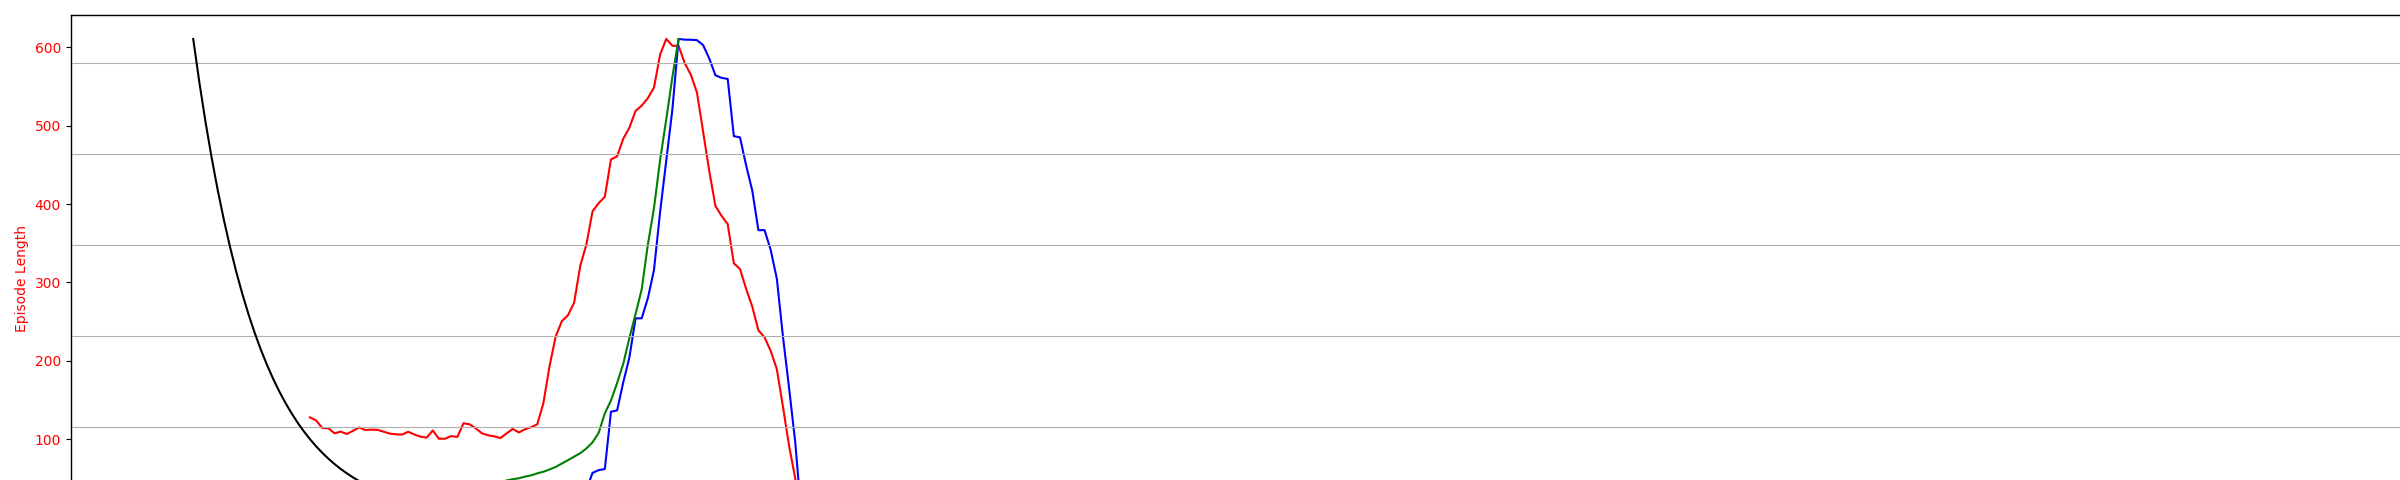

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal bol

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Umpush' (Umpush-Light.ttf) normal normal light normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kinnari' (Kinnari-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu Condensed' (Ubuntu-C.ttf) normal normal 400 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Keraleeyam' (Keraleeyam.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Nakula' (nakula.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'FreeSans' (FreeSansBold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Jamrul' (JamrulNormal.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu' (Ubuntu-MI.ttf) italic normal medium normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Type

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Samyak Devanagari' (Samyak-Devanagari.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Padauk Book' (PadaukBook-Bold.ttf) normal normal book normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Typo' (TlwgTypo.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Typist' (TlwgTypist-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Rachana' (Rachana-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'padmaa' (padmaa.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kinnari' (Kinnari-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mitra Mono' (mitra.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Fo

In [ ]:
#w = poleWorker( nameserver='127.0.0.1',run_id='rl_project_ftw', id=0)
#cs = w.get_configspace()
config = {'action_dim': 13, 'activation': 'tanh', 'decay_rate': 0.09508549692132386, 'dropout_rate': 0.0, 'epsilon': 0.5260053966918045, 'gamma': 0.99, 'hidden_dim': 128, 'lr': 0.001, 'seed': 444}
#config = {'action_dim': 4, 'activation': 'tanh', 'decay_rate': 0.016892393061542884, 'dropout_rate': 0.0, 'epsilon': 0.34479915420926155, 'gamma': 0.99, 'hidden_dim': 16, 'lr': 0.001, 'seed': 616}
#config = {'action_dim': 3, 'activation': 'tanh', 'decay_rate': 0.009764802821466233, 'dropout_rate': 0.0, 'epsilon': 0.46524290948619995, 'gamma': 0.99, 'hidden_dim': 64, 'lr': 0.001, 'seed': 690}
#config = {'action_dim': 6, 'activation': 'tanh', 'decay_rate': 0.003903235822749838, 'dropout_rate': 0.06756115724199396, 'epsilon': 0.4783669314917071, 'gamma': 0.99, 'hidden_dim': 256, 'lr': 0.0025089549673601485, 'seed': 3385}
budget = 400
env = ContinuousCartPoleEnv()
state_dim = env.observation_space.shape[0]
# Try to ensure determinism
############################
torch.manual_seed(config['seed'])
env.seed(config['seed'])
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
############################
conf = {'lr':config['lr'], 'bs':64, 'loss':nn.MSELoss(), 'hidden_dim':config['hidden_dim'],
        'mem_size':1e6, 'activation':config['activation'], 'epsilon':config['epsilon'], 
        'eps_scheduler':'exp', 'n_episodes':budget, 'dropout_rate': config['dropout_rate'], 'n_cycles': 1,
        'decay_rate': config['decay_rate']
      }
#conf = {'lr':config['lr'], 'bs':64, 'loss':nn.MSELoss(), 'hidden_dim':config['hidden_dim'],
#        'mem_size':50000, 'activation':config['activation'], 'epsilon':config['epsilon'], 
#        'eps_scheduler':'exp', 'n_episodes':budget, 'dropout_rate': config['dropout_rate'], 'n_cycles': 1,
#        'decay_rate': config['decay_rate']
#      }

dqn = DQN(state_dim, config['action_dim'], gamma=config['gamma'], conf=conf)
time_steps = 1000
stats = dqn.train(int(budget), time_steps, env, conf)

In [4]:
#env = ContinuousCartPoleEnv()
#state_dim = env.observation_space.shape[0]
#action_dim = 10
#episodes = 10000
#conf = {'lr':0.001, 'bs':64, 'loss':nn.MSELoss(), 'hidden_dim':128,
#        'mem_size':1e6, 'activation':torch.tanh, 'epsilon':1., 'cos_ann':True,
#       'n_episodes':episodes, 'n_cycles':1, 
#      }

#dqn = DQN(state_dim, action_dim, gamma=0.99, conf=conf)
#dqn._q.load_state_dict(torch.load('./model3.pth'))
#dqn._q.eval()
env = ContinuousCartPoleEnv()

for _ in range(6):
    s = env.reset()
    for _ in range(3000):
        #time.sleep(0.005)
        env.render()
        action = dqn.get_action(s, 0.)
        s, r, d, _ = env.step(dqn.action.act(action))  #(action - 5)/6])) 
        if d:
            break

In [5]:
torch.save(dqn._q.state_dict(), './model_final.pth')

e-greedy depending on maximal reward